In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import string
import xgboost as xgb
import io
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
def return_sia_compound_values(text):
    return sia.polarity_scores(text)['compound']

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
def remove_stopword(text):
    new_text = []
    for e in text:
        if e not in stopwords and e.isalpha():
            new_text.append(e)
    text = new_text
    return " ".join(new_text)

def stemm(text):
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

def contains_punctuation(text):
    punctuation = set(string.punctuation)
    for character in text:
        if character in punctuation:
            return True
    return False

def amount_of_punctuation(text):
    punctuation = set(string.punctuation)
    amount = 0
    for character in text:
        if character in punctuation: amount += 1
    return amount

In [4]:
tweets = pd.read_csv("train.csv", usecols=['id','text', 'target'])
test = pd.read_csv("test.csv")

In [5]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7434 non-null   int64 
 1   text    7434 non-null   object
 2   target  7434 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 232.3+ KB


# Fichur Inginierin


In [6]:
tweets_metrics = tweets[['id','text','target']]
tweets_metrics['text_without_stopwords'] = tweets_metrics['text'].str.split()
tweets_metrics['text_without_stopwords'] = tweets_metrics['text_without_stopwords'].apply(remove_stopword)

tweets_metrics['length'] = tweets_metrics['text'].apply(lambda x: len(x))
tweets_metrics['avg_word_length'] = tweets_metrics['text'].str.split().apply(lambda x: [len(y) for y in x]).transform(lambda x: np.mean(x))
tweets_metrics['amount_of_words'] = tweets_metrics['text'].str.split().transform(lambda x: len(x))
unique_words_by_tweet = tweets_metrics['text'].transform(lambda x: x.split()).transform(lambda x: pd.Series(x).unique()).transform(lambda x: len(x))
tweets_metrics['amount_of_unique_words'] = unique_words_by_tweet
tweets_metrics['sentiment'] = tweets_metrics['text'].apply(lambda x: return_sia_compound_values(x))
tweets_metrics['stopwords_count'] = tweets_metrics['text'].apply(lambda x: len([word for word in str(x).lower().split() if word in stopwords]))
tweets_metrics['punctuation_count'] = tweets_metrics['text'].apply(lambda x: amount_of_punctuation(x))
mentions = tweets_metrics['text'].str.findall(r'@.\S*?(?=\s|[:]|$)').to_frame()
tweets_metrics['mentions_count'] = mentions['text'].apply(lambda x: len(x))
hashtags = tweets_metrics['text'].str.findall(r'#[^?\s].*?(?=\s|$)')
tweets_metrics['hashtags_count'] = hashtags.apply(lambda x: len(x))
tweets_metrics['longest_word_length_without_stopwords'] = tweets_metrics['text_without_stopwords'].apply(lambda x: ([len(word) for word in str(x).lower().split() if not word.startswith('http')])).apply(lambda x: max(x) if len(x) > 0 else 0)

tweets_metrics.head()

,id,text,target,text_without_stopwords,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds Reason May ALLAH Forgive us,69,4.384615,13,13,0.2732,6,1,0,1,7
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Canada,38,4.571429,7,7,-0.3400,0,1,0,0,6
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked notified No evacuation she...,133,5.090909,22,20,-0.2960,11,3,0,0,10
3,6,"13,000 people receive #wildfires evacuation or...",1,people receive evacuation orders California,65,7.125000,8,8,0.0000,1,2,0,1,10
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent photo Ruby smoke pours school,88,4.500000,16,15,0.0000,7,2,0,2,6


# Modelos

## XGB Con solo los features basicos

In [8]:
x_train, x_test, y_train, y_test = \
train_test_split(tweets_metrics[['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']], tweets_metrics['target'], test_size = 0.25, random_state = 123)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [9]:
xg_reg = xgb.XGBRegressor(objective ='binary:logistic',
                colsample_bytree = 0.35, learning_rate = 0.3,
                max_depth = 10, alpha = 10, n_estimators = 100)

In [10]:
xg_reg.fit(x_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.35, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='binary:logistic', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [11]:
preds = xg_reg.predict(x_test)
print(preds)

[0.5163653  0.30542597 0.7917713  ... 0.22494091 0.5089964  0.93277615]


In [12]:
for i in range (0, len(preds)):
    if i <= 0.5:       
        preds[i] = 1 
    else:  
        preds[i]=0

In [13]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,y_test)
print(accuracy)

0.5669714900484131


## XGB Con TFIDF + basic features

In [14]:
vectorizer = TfidfVectorizer()
tfidf_lgbm = vectorizer.fit_transform(tweets_metrics.loc[:, 'text'])
array = tfidf_lgbm.todense()


In [15]:
df = pd.DataFrame(array)
df['output'] = tweets['target']
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21520,21521,21522,21523,21524,21525,21526,21527,21528,output
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.416232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [16]:
basic_features = tweets_metrics[['length','avg_word_length','amount_of_words','amount_of_unique_words','sentiment','stopwords_count','punctuation_count','mentions_count','hashtags_count','longest_word_length_without_stopwords']]
basic_features.head()

,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords
0,69,4.384615,13,13,0.2732,6,1,0,1,7
1,38,4.571429,7,7,-0.3400,0,1,0,0,6
2,133,5.090909,22,20,-0.2960,11,3,0,0,10
3,65,7.125000,8,8,0.0000,1,2,0,1,10
4,88,4.500000,16,15,0.0000,7,2,0,2,6


In [17]:
tfidf_features = df.merge(basic_features, left_index = True, right_index = True)
tfidf_features

,0,1,2,3,4,5,6,7,8,9,...,length,avg_word_length,amount_of_words,amount_of_unique_words,sentiment,stopwords_count,punctuation_count,mentions_count,hashtags_count,longest_word_length_without_stopwords
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,69,4.384615,13,13,0.2732,6,1,0,1,7
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38,4.571429,7,7,-0.3400,0,1,0,0,6
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,133,5.090909,22,20,-0.2960,11,3,0,0,10
3,0.0,0.416232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,65,7.125000,8,8,0.0000,1,2,0,1,10
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88,4.500000,16,15,0.0000,7,2,0,2,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7429,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,136,7.058824,17,17,-0.7579,2,15,0,1,10
7430,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,105,6.571429,14,14,-0.7579,2,9,0,1,10
7431,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,134,5.428571,21,21,0.9164,5,9,0,0,8
7432,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,139,4.384615,26,21,0.4118,9,7,0,0,7


In [18]:
features = tfidf_features.columns.drop('output')
x = tfidf_features.loc[:, features].values
y = tfidf_features.loc[:, 'output'].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 123)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [19]:
xg_reg = xgb.XGBRegressor(objective ='reg:squaredlogerror',
                colsample_bytree = 0.35, learning_rate = 0.3,
                max_depth = 10, alpha = 10, n_estimators = 100)

In [20]:
xg_reg.fit(x_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.35, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squaredlogerror', random_state=0, reg_alpha=10,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [21]:
preds = xg_reg.predict(x_test)
print(preds)

[0.02826667 0.50269556 0.3732233  ... 0.56165004 0.47912255 0.26313388]


In [22]:
for i in range (0, len(preds)):
    if i <= 0.5:       
        preds[i] = 1 
    else:  
        preds[i]=0

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(preds,y_test)
print(accuracy)

0.5908590308370044


## Redes neuronales

### Vectorizer and Logistic Regression: first steps

In [7]:
x = tweets_metrics['text'].values
y = tweets_metrics['target'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1000)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,1), lowercase = True)#binary = True
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)
x_train

<5575x17366 sparse matrix of type '<class 'numpy.int64'>'
	with 54316 stored elements in Compressed Sparse Row format>

In [9]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print("Accuracy:", score)

Accuracy: 0.8031199569661108


### Keras: first model using count vectorizer

In [138]:
x = tweets_metrics['text'].values
y = tweets_metrics['target'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1000)

vectorizer = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1,1), lowercase = True)#binary = True
vectorizer.fit(x_train)

x_train = vectorizer.transform(x_train)
x_test  = vectorizer.transform(x_test)

In [139]:
from keras.models import Sequential
from keras import layers

input_dim = x_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(15, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 10)                173670    
_________________________________________________________________
dense_54 (Dense)             (None, 15)                165       
_________________________________________________________________
dense_55 (Dense)             (None, 1)                 16        
Total params: 173,851
Trainable params: 173,851
Non-trainable params: 0
_________________________________________________________________


In [140]:
history = model.fit(x_train, y_train,\
                         epochs=2,\
                         verbose=False,\
                         validation_data=(x_test, y_test),\
                         batch_size=45)

In [141]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9283
Testing Accuracy:  0.8085


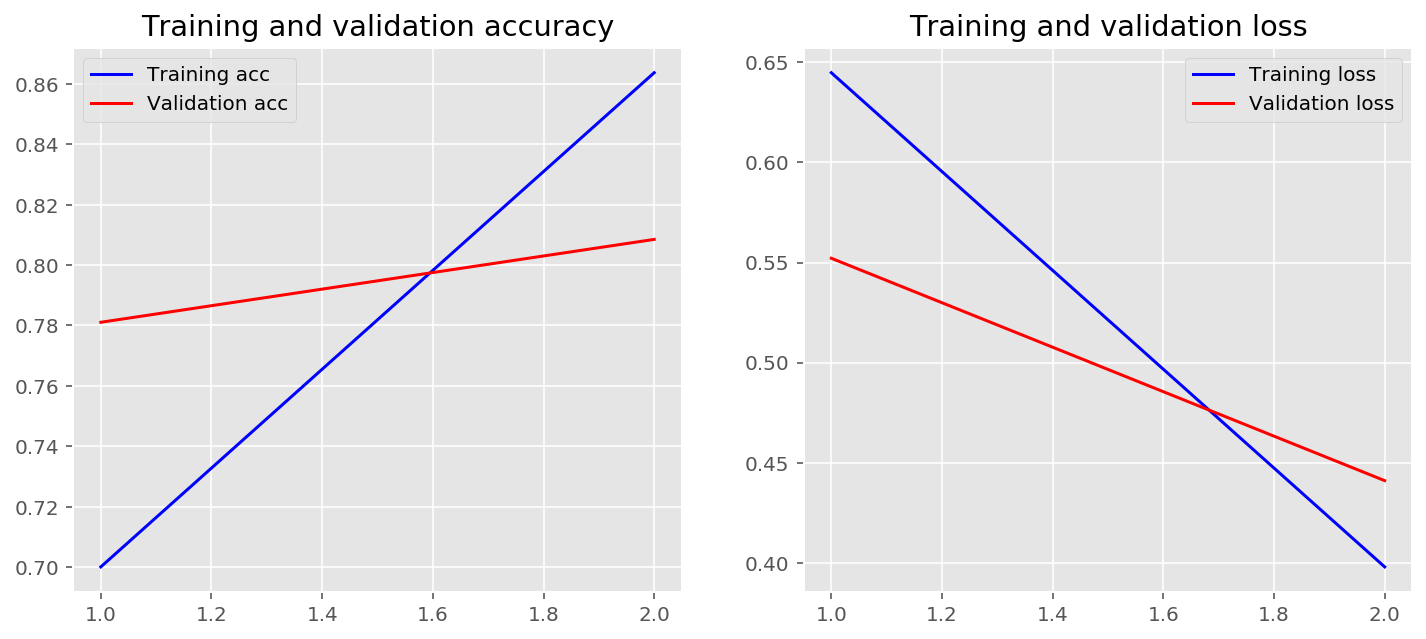

In [142]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

### Keras: using embedding: Tokenizer + pooling + flatten

In [151]:
from keras.preprocessing.text import Tokenizer

x = tweets_metrics['text'].values
y = tweets_metrics['target'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1000)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

In [152]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [153]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           932900    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 50)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 10)                510       
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 11        
Total params: 933,421
Trainable params: 933,421
Non-trainable params: 0
_________________________________________________________________


In [154]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=45)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9587
Testing Accuracy:  0.7972


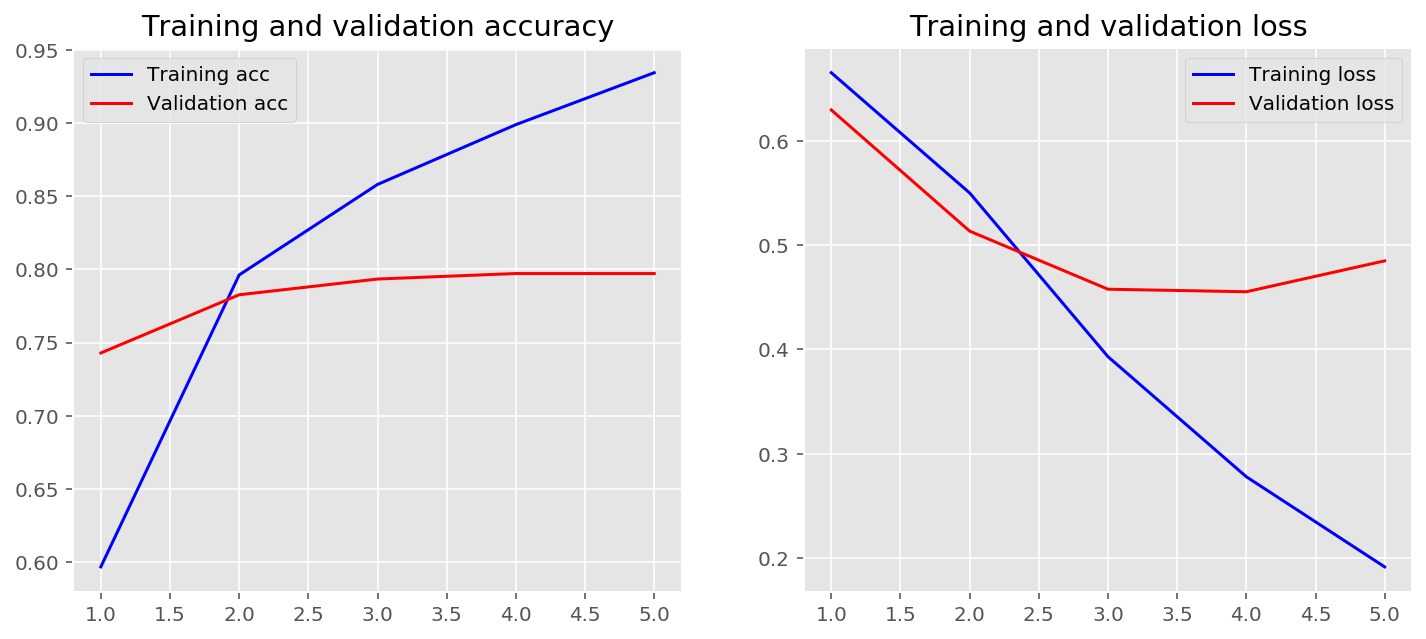

In [155]:
plot_history(history)

### Keras con palabras preprocesadas

In [209]:
from keras.preprocessing.text import Tokenizer

x = tweets_metrics['text'].values
y = tweets_metrics['target'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 1000)

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1

from keras.preprocessing.sequence import pad_sequences

maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [210]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf-8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove.6B.50d.txt',tokenizer.word_index, embedding_dim)

In [211]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.5723014256619144

In [212]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 100)          1865800   
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 100)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 10)                1010      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 11        
Total params: 1,866,821
Trainable params: 1,866,821
Non-trainable params: 0
_________________________________________________________________


In [213]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(x_test, y_test),
                    batch_size=45)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9521
Testing Accuracy:  0.7913


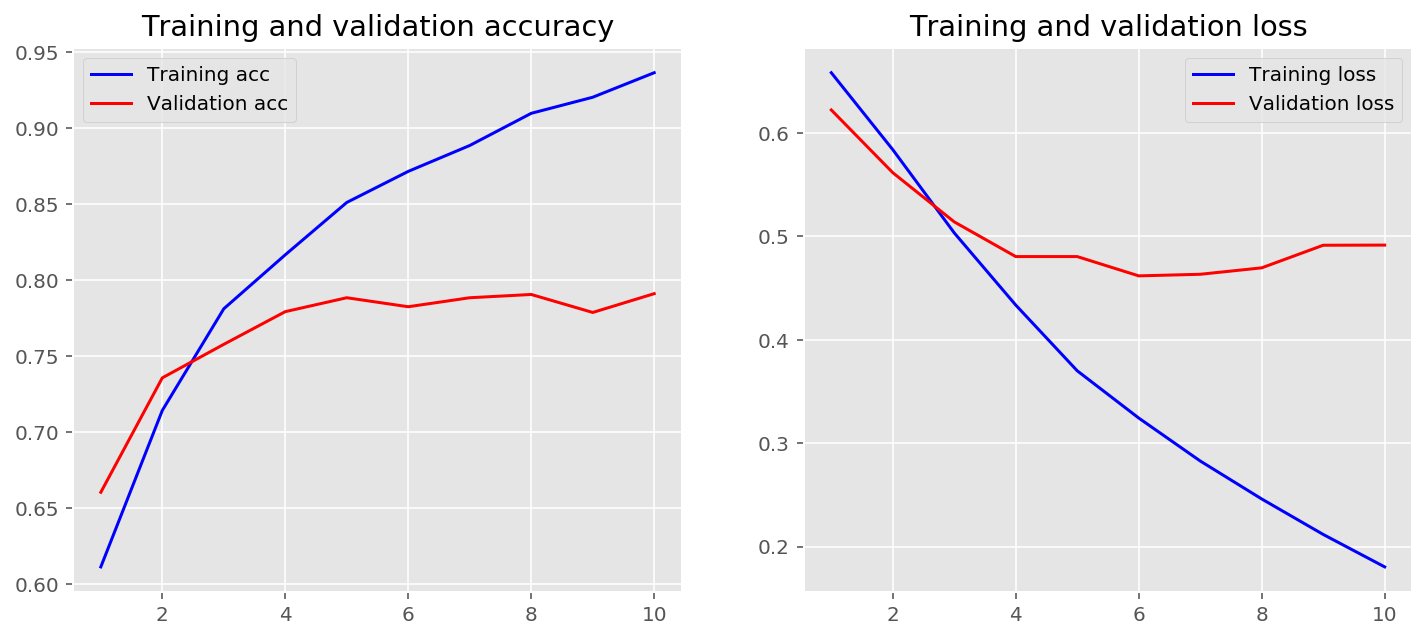

In [214]:
plot_history(history)